In [2]:
from pathlib import Path
import torch
import scanpy as sc
import matplotlib.pyplot as plt

from homework_scientalab.config import (
    load_data_config,
    load_train_config,
)

from homework_scientalab.train import train 
from homework_scientalab.validation.visualize_latent import (
    get_latent_representations,
    compute_batch_correction_metrics,
)

# Set matplotlib backend for better display
plt.rcParams['figure.dpi'] = 100

print("✓ Imports complete")

✓ Imports complete


In [3]:
# Load default configurations
data_cfg = load_data_config()
train_cfg = load_train_config()

# Optional: Override specific parameters
train_cfg.n_epochs = 50  # Adjust as needed
train_cfg.z_i_dim = 30   # Biological latent dimensions
train_cfg.z_s_dim = 5    # Technical/batch latent dimensions
train_cfg.batch_size = 256
train_cfg.learning_rate = 0.001

print("\nConfiguration loaded:")
print(f"  Data path: {data_cfg.data_path}")
print(f"  N top genes: {data_cfg.n_top_genes}")
print(f"  Val size: {data_cfg.val_size}")
print(f"  Epochs: {train_cfg.n_epochs}")
print(f"  Batch size: {train_cfg.batch_size}")
print(f"  Learning rate: {train_cfg.learning_rate}")
print(f"  Latent dims: z_i={train_cfg.z_i_dim}, z_s={train_cfg.z_s_dim}")

# change config data path
data_cfg.data_path = "../data/pancreas_processed.h5ad"



Configuration loaded:
  Data path: data/pancreas.h5ad
  N top genes: 4000
  Val size: 0.2
  Epochs: 50
  Batch size: 256
  Learning rate: 0.001
  Latent dims: z_i=30, z_s=5


In [4]:
# Set random seed for reproducibility
# import set seed
from homework_scientalab.monitor_and_setup.reproducibility import set_seed

set_seed(train_cfg.seed, train_cfg.deterministic)
print(f"✓ Random seed set to {train_cfg.seed}")


# Load preprocessed data for later visualization
adata = sc.read(data_cfg.data_path)
print(f"✓ Loaded preprocessed AnnData: {adata.shape}")

INFO Set random seed to 42 (deterministic=True)


✓ Random seed set to 42
✓ Loaded preprocessed AnnData: (9025, 2443)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Train model using the train() function from train.py
# This handles model creation, optimizer setup, training loop, and checkpointing
model = train(
    train_cfg=train_cfg,
    data_cfg=data_cfg,
    device=device,
    use_wandb=False,  # Set to True if you want W&B logging
)


INFO Set random seed to 42 (deterministic=True)


Using device: cuda
Setting random seed to 42 (deterministic=True)
Using device: cuda
DATA PREPARATION PIPELINE
Loading data from ../data/pancreas_processed.h5ad...
Initial shape: (9025, 2443)
Cell types:
celltype
alpha                     2435
beta                      1747
ductal                    1618
acinar                     990
delta                      439
not applicable             404
gamma                      363
activated_stellate         252
endothelial                218
dropped                    172
quiescent_stellate         101
mesenchymal                 80
PSC                         54
macrophage                  42
co-expression               39
mesenchyme                  27
epsilon                     13
schwann                      8
unclassified endocrine       7
MHC class II                 5
mast                         5
unclear                      4
unclassified                 2
Name: count, dtype: int64
Batches:
batch
0    3731
2    2560
1    2126
3  

/mnt/user_disk/larnould/scientalab/src/homework_scientalab/data.py:106: RuntimeWarning: invalid value encountered in cast
  counts_arr = np.rint(np.clip(np.asarray(counts_source), 0, None)).astype(np.int64, copy=False)


After QC: (9025, 2443)
After count filtering [100, 15000]: (4525, 2443) (removed 4500 cells)


: 

In [ ]:
from homework_scientalab.model import InVAE
from homework_scientalab.config import InVAEConfig

# Load best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_dir = Path(train_cfg.save_dir)
checkpoint_path = save_dir / "best_model.pt"


checkpoint_path = "../checkpoints/best_model.pt"
print(f"Loading best model from {checkpoint_path}...")


checkpoint = torch.load(checkpoint_path, map_location=device)

# Reconstruct model from config stored in checkpoint
model_cfg = InVAEConfig(**checkpoint["model_config"])
model = InVAE(model_cfg)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

print("✓ Model loaded")
print(f"  Epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Val loss: {checkpoint.get('val_loss', 'N/A'):.4f}")

# Extract latent representations
print("\nExtracting z_i (invariant) and z_s (spurious) representations...")
z_i, z_s = get_latent_representations(
    model=model,
    adata=adata,
    batch_key=data_cfg.batch_key,
    celltype_key=data_cfg.celltype_key,
    batch_size=train_cfg.batch_size,
)

print(f"✓ Latent representations extracted:")
print(f"  z_i (invariant): {z_i.shape}")
print(f"  z_s (spurious): {z_s.shape}")

# Add to AnnData
adata.obsm["X_z_i"] = z_i
adata.obsm["X_z_s"] = z_s
print("✓ Added to AnnData.obsm")


Loading best model from ../checkpoints/best_model.pt...
✓ Model loaded
  Epoch: 50
  Val loss: 1129.1562

Extracting z_i (invariant) and z_s (spurious) representations...


/mnt/user_disk/larnould/scientalab/.venv/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return F.linear(input, self.weight, self.bias)


✓ Latent representations extracted:
  z_i (invariant): (9025, 30)
  z_s (spurious): (9025, 5)
✓ Added to AnnData.obsm


In [11]:
# Create copies for different representations
adata_raw = adata.copy()
adata_inv = adata.copy()
adata_spur = adata.copy()

# Raw data UMAP
print("Computing UMAP for raw data...")
if "X_umap" not in adata_raw.obsm:
    sc.pp.neighbors(adata_raw, n_neighbors=15)
    sc.tl.umap(adata_raw)
print("✓ Raw data UMAP")

# Invariant space UMAP
print("Computing UMAP for invariant space (z_i)...")
sc.pp.neighbors(adata_inv, use_rep="X_z_i", n_neighbors=15)
sc.tl.umap(adata_inv)
print("✓ Invariant space UMAP")

# Spurious space UMAP
print("Computing UMAP for spurious space (z_s)...")
sc.pp.neighbors(adata_spur, use_rep="X_z_s", n_neighbors=15)
sc.tl.umap(adata_spur)
print("✓ Spurious space UMAP")


Computing UMAP for raw data...
✓ Raw data UMAP
Computing UMAP for invariant space (z_i)...


/mnt/user_disk/larnould/scientalab/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Invariant space UMAP
Computing UMAP for spurious space (z_s)...
✓ Spurious space UMAP


✓ Saved: validation_results/latent_vis/latent_comparison.png


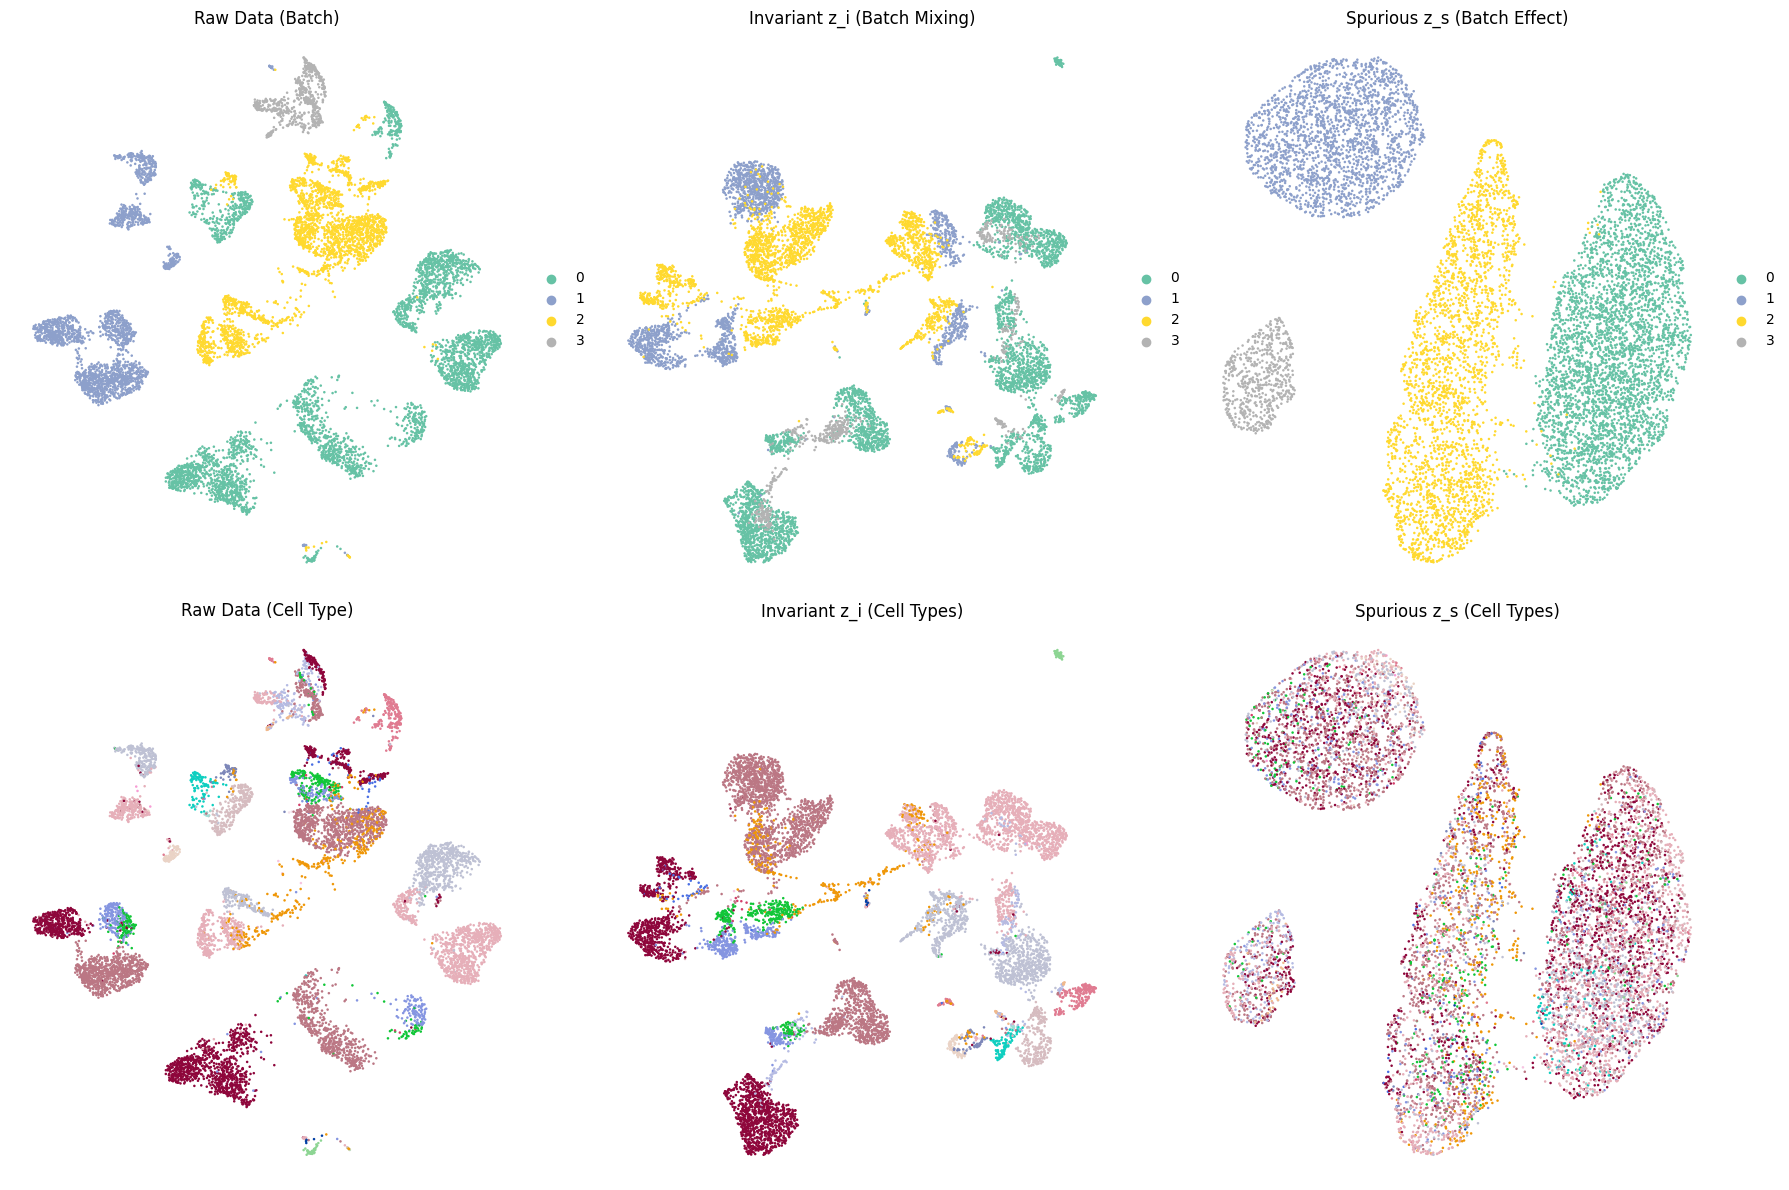

In [12]:
output_dir = Path("validation_results/latent_vis")
output_dir.mkdir(parents=True, exist_ok=True)

# Main comparison plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Colored by batch
sc.pl.umap(adata_raw, color=data_cfg.batch_key, ax=axes[0, 0], show=False,
           title="Raw Data (Batch)", palette="Set2", frameon=False)
sc.pl.umap(adata_inv, color=data_cfg.batch_key, ax=axes[0, 1], show=False,
           title="Invariant z_i (Batch Mixing)", palette="Set2", frameon=False)
sc.pl.umap(adata_spur, color=data_cfg.batch_key, ax=axes[0, 2], show=False,
           title="Spurious z_s (Batch Effect)", palette="Set2", frameon=False)

# Row 2: Colored by cell type
sc.pl.umap(adata_raw, color=data_cfg.celltype_key, ax=axes[1, 0], show=False,
           title="Raw Data (Cell Type)", legend_loc=None, frameon=False)
sc.pl.umap(adata_inv, color=data_cfg.celltype_key, ax=axes[1, 1], show=False,
           title="Invariant z_i (Cell Types)", legend_loc=None, frameon=False)
sc.pl.umap(adata_spur, color=data_cfg.celltype_key, ax=axes[1, 2], show=False,
           title="Spurious z_s (Cell Types)", legend_loc=None, frameon=False)

plt.tight_layout()
save_path = output_dir / "latent_comparison.png"
plt.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"✓ Saved: {save_path}")
plt.show()

✓ Saved: validation_results/latent_vis/batch_correction_comparison.png


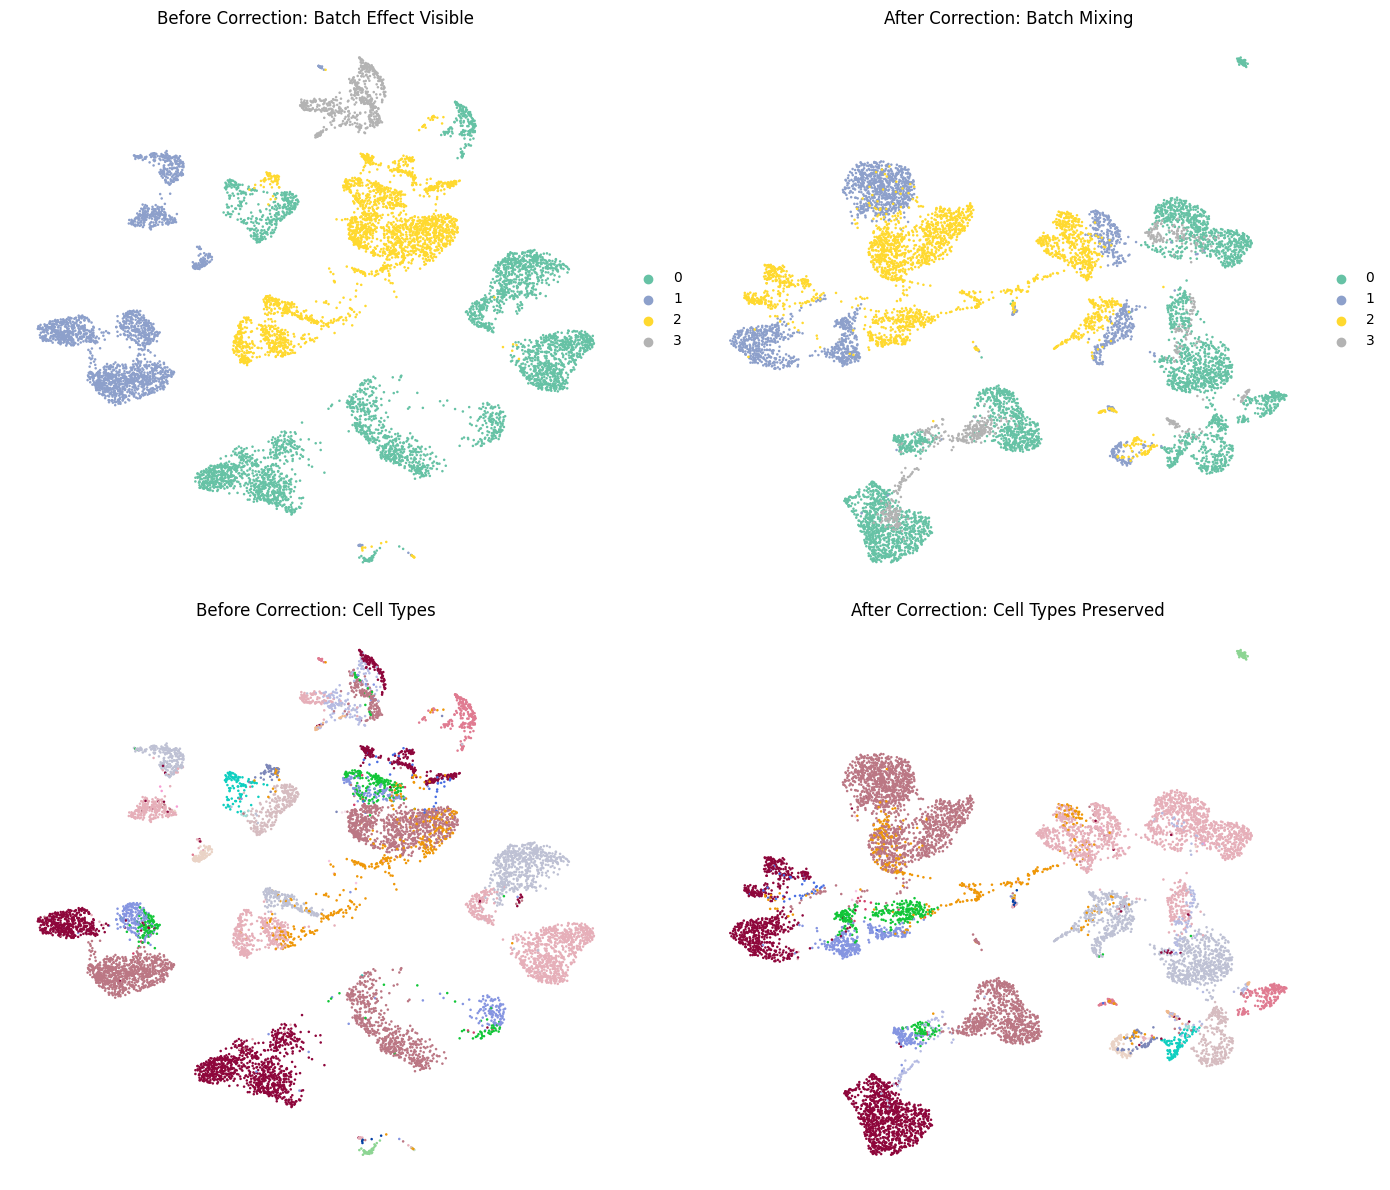

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Raw data
sc.pl.umap(adata_raw, color=data_cfg.batch_key, ax=axes[0, 0], show=False,
           title="Before Correction: Batch Effect Visible", palette="Set2", frameon=False)
sc.pl.umap(adata_raw, color=data_cfg.celltype_key, ax=axes[1, 0], show=False,
           title="Before Correction: Cell Types", legend_loc=None, frameon=False)

# Corrected data
sc.pl.umap(adata_inv, color=data_cfg.batch_key, ax=axes[0, 1], show=False,
           title="After Correction: Batch Mixing", palette="Set2", frameon=False)
sc.pl.umap(adata_inv, color=data_cfg.celltype_key, ax=axes[1, 1], show=False,
           title="After Correction: Cell Types Preserved", legend_loc=None, frameon=False)

plt.tight_layout()
save_path = output_dir / "batch_correction_comparison.png"
plt.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"✓ Saved: {save_path}")
plt.show()

In [14]:
print("\n" + "="*80)
print("BATCH CORRECTION METRICS")
print("="*80)

# Compute metrics for raw data
raw_metrics = compute_batch_correction_metrics(
    adata_raw,
    batch_key=data_cfg.batch_key,
    celltype_key=data_cfg.celltype_key,
    representation="X_umap",
)

# Compute metrics for corrected data
inv_metrics = compute_batch_correction_metrics(
    adata_inv,
    batch_key=data_cfg.batch_key,
    celltype_key=data_cfg.celltype_key,
    representation="X_z_i",
)

print("\nRaw Data Metrics:")
for key, value in raw_metrics.items():
    print(f"  {key}: {value:.4f}")

print("\nCorrected Data Metrics:")
for key, value in inv_metrics.items():
    print(f"  {key}: {value:.4f}")

print("\nMetrics Interpretation:")
print("  • Batch ASW (↓ better): Measures batch separation (lower = more mixing)")
print("  • Cell Type ASW (preserve): Measures biological separation (high = good)")
print("  • Batch Mixing Entropy (↑ better): Measures batch diversity in neighborhoods")

# Compute improvements
batch_asw_improvement = raw_metrics["batch_asw"] - inv_metrics["batch_asw"]
celltype_asw_change = inv_metrics["celltype_asw"] - raw_metrics["celltype_asw"]
entropy_improvement = inv_metrics["batch_mixing_entropy"] - raw_metrics["batch_mixing_entropy"]

print(f"\n📊 Summary:")
print(f"  Batch ASW: {raw_metrics['batch_asw']:.4f} → {inv_metrics['batch_asw']:.4f} "
      f"({'✅ improved' if batch_asw_improvement > 0.05 else '⚠️ marginal'})")
print(f"  Cell Type ASW: {raw_metrics['celltype_asw']:.4f} → {inv_metrics['celltype_asw']:.4f} "
      f"({'✅ preserved' if abs(celltype_asw_change) < 0.1 else '⚠️ changed'})")
print(f"  Batch Mixing: {raw_metrics['batch_mixing_entropy']:.4f} → {inv_metrics['batch_mixing_entropy']:.4f} "
      f"({'✅ improved' if entropy_improvement > 0.05 else '⚠️ marginal'})")



BATCH CORRECTION METRICS

Raw Data Metrics:
  batch_asw: 0.2382
  celltype_asw: -0.2948
  batch_mixing_entropy: 0.0151
  batch_mixing_entropy_std: 0.0927

Corrected Data Metrics:
  batch_asw: 0.0011
  celltype_asw: 0.1918
  batch_mixing_entropy: 0.1608
  batch_mixing_entropy_std: 0.2539

Metrics Interpretation:
  • Batch ASW (↓ better): Measures batch separation (lower = more mixing)
  • Cell Type ASW (preserve): Measures biological separation (high = good)
  • Batch Mixing Entropy (↑ better): Measures batch diversity in neighborhoods

📊 Summary:
  Batch ASW: 0.2382 → 0.0011 (✅ improved)
  Cell Type ASW: -0.2948 → 0.1918 (⚠️ changed)
  Batch Mixing: 0.0151 → 0.1608 (✅ improved)



TRAIN set (7220 cells):
  Raw - Batch ASW: 0.2271, Cell Type ASW: -0.2899
  Corrected - Batch ASW: -0.0003, Cell Type ASW: 0.2171
  ✓ Saved: validation_results/latent_vis/train_comparison.png


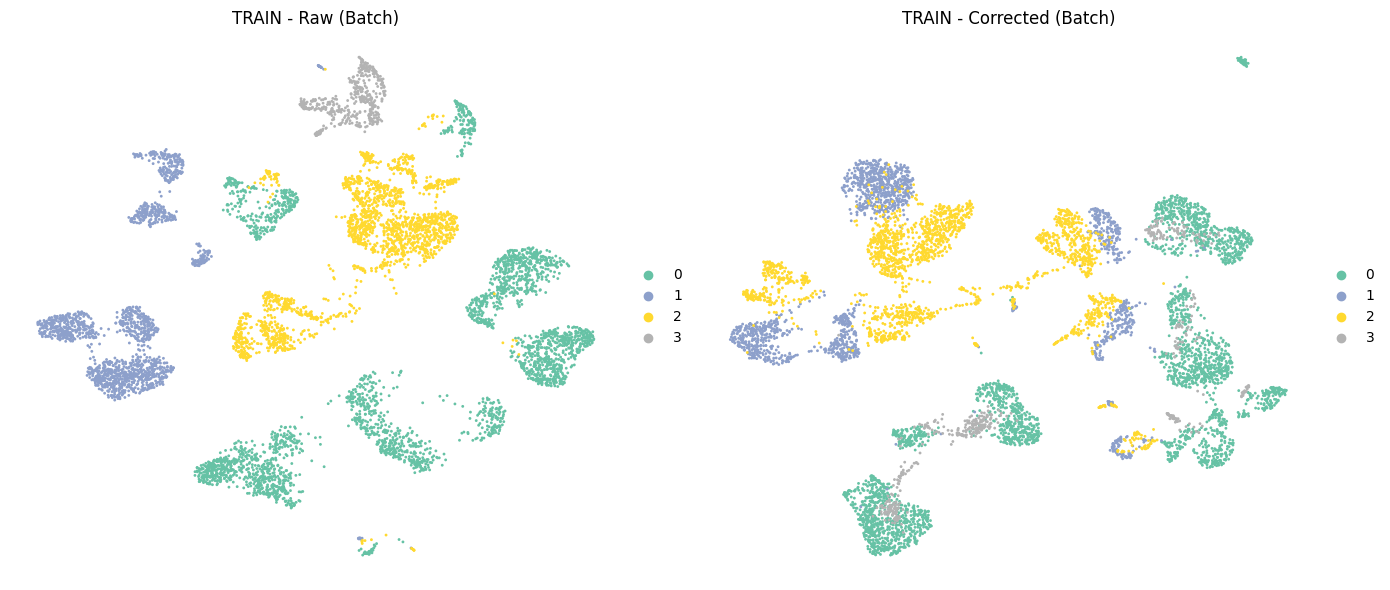


VAL set (1805 cells):
  Raw - Batch ASW: 0.2427, Cell Type ASW: -0.3229
  Corrected - Batch ASW: -0.0153, Cell Type ASW: 0.1833
  ✓ Saved: validation_results/latent_vis/val_comparison.png


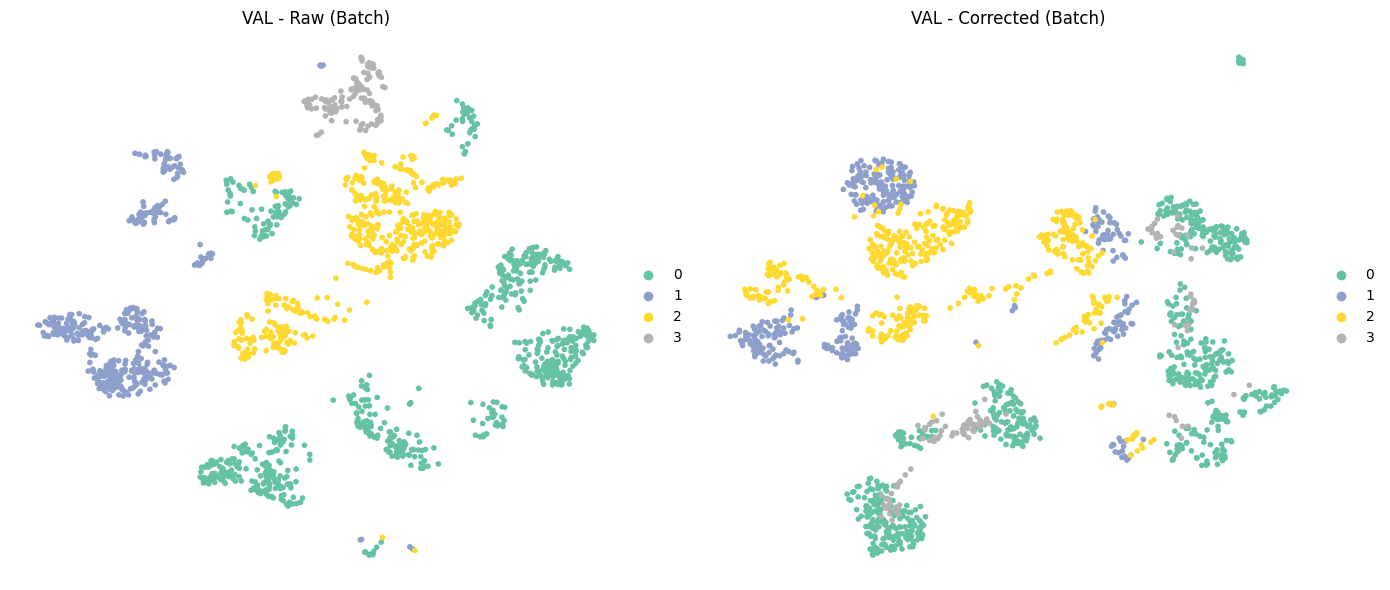

In [15]:
if "split" in adata.obs.columns:
    
    for split_name in ["train", "val"]:
        mask = adata.obs["split"] == split_name
        n_cells = mask.sum()
        print(f"\n{split_name.upper()} set ({n_cells} cells):")
        
        # Subset data
        adata_raw_sub = adata_raw[mask].copy()
        adata_inv_sub = adata_inv[mask].copy()
        
        # Compute metrics
        raw_met = compute_batch_correction_metrics(
            adata_raw_sub, data_cfg.batch_key, data_cfg.celltype_key, "X_umap"
        )
        inv_met = compute_batch_correction_metrics(
            adata_inv_sub, data_cfg.batch_key, data_cfg.celltype_key, "X_z_i"
        )
        
        print(f"  Raw - Batch ASW: {raw_met['batch_asw']:.4f}, "
              f"Cell Type ASW: {raw_met['celltype_asw']:.4f}")
        print(f"  Corrected - Batch ASW: {inv_met['batch_asw']:.4f}, "
              f"Cell Type ASW: {inv_met['celltype_asw']:.4f}")
        
        # Create plots
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        sc.pl.umap(adata_raw_sub, color=data_cfg.batch_key, ax=axes[0], show=False,
                   title=f"{split_name.upper()} - Raw (Batch)", palette="Set2", frameon=False)
        sc.pl.umap(adata_inv_sub, color=data_cfg.batch_key, ax=axes[1], show=False,
                   title=f"{split_name.upper()} - Corrected (Batch)", palette="Set2", frameon=False)
        
        plt.tight_layout()
        save_path = output_dir / f"{split_name}_comparison.png"
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
        print(f"  ✓ Saved: {save_path}")
        plt.show()